In [ ]:
#pip install num2words

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import re
import math

In [ ]:
#!unzip stories

In [ ]:
title = "stories"
alpha = 0.3

##Taking all folders

In [ ]:
folders = [x[0] for x in os.walk(str(os.getcwd())+'/'+title+'/')] #os.walk gives us the files in the directory, os.getcwd gives us the 
#current directory and title and we are going to search in the current directory + stories folder as our data files are in the stories folder.
folders[0] = folders[0][:len(folders[0])-1]# if we don't write this line, /content/stories/ extra slash will appear.
#Now we can find that folders give extra / for the root folder, so we are going to remove it.

In [ ]:
folders

['/content/stories', '/content/stories/FARNON', '/content/stories/SRE']

In [ ]:
folders[0]

'/content/stories'

##Collecting the file names and titles

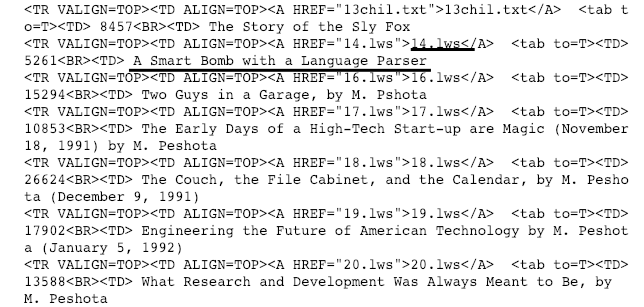

In [ ]:
dataset = []

c = False

for i in folders:
    file = open(i+"/index.html", 'r')
    text = file.read().strip() #The strip() method removes any leading (spaces at the beginning) and trailing (spaces at the end) characters (space is the default leading character to remove)
    file.close()
#We can clearly observe that each file name is enclosed between (><A HREF=”) and (”) and each title is between (<BR><TD>) and (\n)
#We will use simple regular expressions to retrieve the name and title.
    file_name = re.findall('><A HREF="(.*)">', text)
    file_title = re.findall('<BR><TD> (.*)\n', text)

    if c == False:
        file_name = file_name[2:]  #for removing the links which are there with title and name 
        c = True
        
    print(len(file_name), len(file_title))

    for j in range(len(file_name)):
        dataset.append((str(i) +"/"+ str(file_name[j]), file_title[j]))


452 452
0 0
15 15


In [ ]:
len(dataset)

467

In [ ]:
dataset

[('/content/stories/100west.txt',
  'Going 100 West by 53 North by Jim Prentice (1990)'),
 ('/content/stories/13chil.txt', 'The Story of the Sly Fox'),
 ('/content/stories/14.lws', 'A Smart Bomb with a Language Parser'),
 ('/content/stories/16.lws', 'Two Guys in a Garage, by M. Pshota'),
 ('/content/stories/17.lws',
  'The Early Days of a High-Tech Start-up are Magic (November 18, 1991) by M. Peshota'),
 ('/content/stories/18.lws',
  'The Couch, the File Cabinet, and the Calendar, by M. Peshota (December 9, 1991)'),
 ('/content/stories/19.lws',
  'Engineering the Future of American Technology by M. Peshota (January 5, 1992)'),
 ('/content/stories/20.lws',
  'What Research and Development Was Always Meant to Be, by M. Peshota'),
 ('/content/stories/3gables.txt', 'The Adventure of the Three Gables'),
 ('/content/stories/3lpigs.txt', 'The Story of the 3 Little Pigs'),
 ('/content/stories/3sonnets.vrs',
  'A Collection of Sonnets by Staeorra Rokraven (March 9, 1989)'),
 ('/content/stories/

In [ ]:
def print_doc(id):
    print(dataset[id])
    file = open(dataset[id][0], 'r', encoding='cp1250')
    text = file.read().strip()
    file.close()
    print(text)

##Preprocessing

In [ ]:
def convert_lower_case(data):
    return np.char.lower(data)

In [ ]:
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [ ]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ') #we are providing data and coverting symbols into empty string
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

In [ ]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

In [ ]:
def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text            #A better efficient way to proceed is to first lemmatise and then stem

In [ ]:
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

we are using numpy here because our data is stored in a list of lists, and numpy is our best bet.When a user gives a query such as 100 dollars or hundred dollars. For the user, both those search terms are the same. but our IR model treats them separately, as we are storing 100, dollars, hundred as different tokens. So to make our IR mode a little better we need to convert 100 to hundred. To achieve this we are going to use a library called num2word.

In [ ]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

the TF of paper in both title and body is the same? Yes, it’s the same! it’s just the difference in weights that we are going to give. If the word is present in both title and body, then there wouldn't be any reduction in the TF-IDF value. If the word is present only in the title, then the weight of the body for that particular word will not add to the TF of that word, and vice versa.
document = body + title
TF-IDF(document) = TF-IDF(title) * alpha + TF-IDF(body) * (1-alpha)

##Extracting Data

In [ ]:
N=len(dataset)

In [ ]:
processed_text = []
processed_title = []

for i in dataset[:N]:
    file = open(i[0], 'r', encoding="utf8", errors='ignore')
    text = file.read().strip()
    file.close()

    processed_text.append(word_tokenize(str(preprocess(text))))
    processed_title.append(word_tokenize(str(preprocess(i[1]))))

##Calculating DF for all words

Let us be smart and calculate DF beforehand. We need to iterate through all the words in all the documents and store the document id’s for each word. For this, we will use a dictionary as we can use the word as the key and a set of documents as the value. I mentioned set because, even if we are trying to add the document multiple times, a set will not just take duplicate values.We are going to create a set if the word doesn’t have a set yet else add it to the set. This condition is checked by the try block. Here processed_text is the body of the document, and we are going to repeat the same for the title as well, as we need to consider the DF of the whole document.
len(DF) will give the unique words
DF will have the word as the key and the list of doc id’s as the value. but for DF we don’t actually need the list of docs, we just need the count. so we are going to replace the list with its count.

In [ ]:
DF = {}

for i in range(N):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

    tokens = processed_title[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
for i in DF:
    DF[i] = len(DF[i])

In [ ]:
total_vocab_size = len(DF)

In [ ]:
total_vocab_size

32350

In [ ]:
total_vocab = [x for x in DF]

In [ ]:
print(total_vocab[:20])


['sharewar', 'trial', 'project', 'freewar', 'need', 'support', 'continu', 'one', 'hundr', 'west', 'fifti', 'three', 'north', 'jim', 'prentic', 'copyright', 'thousand', 'nine', 'nineti', 'brandon']


In [ ]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

Calculating TF-IDF for body, we will consider this as the actual tf-idf as we will add the title weight to this.

In [ ]:
doc = 0

tf_idf = {}

for i in range(N):
    
    tokens = processed_text[i]
    
    counter = Counter(tokens + processed_title[i])
    words_count = len(tokens + processed_title[i])
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))
        
        tf_idf[doc, token] = tf*idf

    doc += 1

Calculating TF-IDF for Title

In [ ]:
doc = 0

tf_idf_title = {}

for i in range(N):
    
    tokens = processed_title[i]
    counter = Counter(tokens + processed_text[i])
    words_count = len(tokens + processed_text[i])

    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1)) #numerator is added 1 to avoid negative values
        
        tf_idf_title[doc, token] = tf*idf

    doc += 1

In [ ]:
tf_idf[(0,"go")]

0.0002906893990853149

In [ ]:
tf_idf_title[(0,"go")]

0.0002906893990853149

Merging the TF-IDF according to weights

In [ ]:
for i in tf_idf:
    tf_idf[i] *= alpha

In [ ]:
for i in tf_idf_title:
    tf_idf[i] = tf_idf_title[i]

In [ ]:
len(tf_idf)

344378

TF-IDF Matching Score Ranking

In [ ]:
def matching_score(k, query):
    preprocessed_query = preprocess(query)
    tokens = word_tokenize(str(preprocessed_query))

    print("Matching Score")
    print("\nQuery:", query)
    print("")
    print(tokens)
    
    query_weights = {}

    for key in tf_idf:
        
        if key[1] in tokens:
            try:
                query_weights[key[0]] += tf_idf[key]
            except:
                query_weights[key[0]] = tf_idf[key]
    
    query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)

    print("")
    
    l = []
    
    for i in query_weights[:10]:
        l.append(i[0])
    
    print(l)
    

matching_score(10, "Without the drive of Rebeccah's insistence, Kate lost her momentum. She stood next a slatted oak bench, canisters still clutched, surveying")

Matching Score

Query: Without the drive of Rebeccah's insistence, Kate lost her momentum. She stood next a slatted oak bench, canisters still clutched, surveying

['without', 'drive', 'rebeccah', 'insist', 'kate', 'lost', 'momentum', 'stood', 'next', 'slat', 'oak', 'bench', 'canist', 'still', 'clutch', 'survey']

[166, 200, 352, 433, 211, 350, 175, 187, 188, 294]


In [ ]:
print_doc(2)


('/content/stories/14.lws', 'A Smart Bomb with a Language Parser')
----------------------------------------------
"The Adventures of Lone Wolf Scientific"
------------------------------------------
An electronically syndicated series that
follows the exploits of two madcap
mavens of high-technology. Copyright 1991
Michy Peshota. All rights reserved.  May
not be distributed without accompanying
WELCOME.LWS and EPISOD.LWS files.
-----------------------
EPISODE #14


           A Smart Bomb with a Language Parser

>>>S-max attempts to thwart The Last Words Bomb's language
parser, but to no avail.  He discovers that program code is
often more stubborn than human will.<<

                      By M. Peshota

     "Whoever heard of a smart bomb with a language parser?"
he heard him grumble.  Austin watched his wild-haired
officemate, his bull-like features creased into a scowl,
hunched over stacks and stacks of thesauruses, whipping
their pages, cursing bitterly.  "Only a nudnik programmer
w

TF-IDF Cosine Similarity Ranking

In [ ]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

Vectorising tf-idf

In [ ]:
D = np.zeros((N, total_vocab_size))
for i in tf_idf:
    try:
        ind = total_vocab.index(i[1])
        D[i[0]][ind] = tf_idf[i]
    except:
        pass

In [ ]:
def gen_vector(tokens):

    Q = np.zeros((len(total_vocab)))
    
    counter = Counter(tokens)
    words_count = len(tokens)

    query_weights = {}
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = math.log((N+1)/(df+1))

        try:
            ind = total_vocab.index(token)
            Q[ind] = tf*idf
        except:
            pass
    return Q

In [ ]:
def cosine_similarity(k, query):
    print("Cosine Similarity")
    preprocessed_query = preprocess(query)
    tokens = word_tokenize(str(preprocessed_query))
    
    print("\nQuery:", query)
    print("")
    print(tokens)
    
    d_cosines = []
    
    query_vector = gen_vector(tokens)
    
    for d in D:
        d_cosines.append(cosine_sim(query_vector, d))
        
    out = np.array(d_cosines).argsort()[-k:][::-1]
    
    print("")
    
    print(out)

#     for i in out:
#         print(i, dataset[i][0])

Q = cosine_similarity(10, "Without the drive of Rebeccah's insistence, Kate lost her momentum. She stood next a slatted oak bench, canisters still clutched, surveying")

Cosine Similarity

Query: Without the drive of Rebeccah's insistence, Kate lost her momentum. She stood next a slatted oak bench, canisters still clutched, surveying

['without', 'drive', 'rebeccah', 'insist', 'kate', 'lost', 'momentum', 'stood', 'next', 'slat', 'oak', 'bench', 'canist', 'still', 'clutch', 'survey']

[200 166 433 175 169 402 211  87 151 369]


In [ ]:
print_doc(200)

('/content/stories/ghost', 'Time for Flowers, by Gay Bost')
TIME FOR FLOWERS
  by Gay Bost

They'd put flowers up. She hadn't noticed. Time wouldn't hold still.
She remembered, quite clearly, that time had been a simple thing; one
moment following the previous one, seconds strung out neatly like her
mother's pearls laid out on the dark mahogany vanity each Sunday
morning. But there had been a catch . . . 

Hung around Mother's neck the catch clicked and the tidy little line 
of seconds became a never ending circle with only the catch in the 
middle. For some reason the thought of pearls gathered from the sea, 
naturally nested within the confines of oyster shells, scattered 
haphazardly about the ocean floor disturbed her.

Now they'd put up the flowers in the same careless groupings. This,
too, disturbed her. Bright yellow trumpets, their collars spread to
catch the sun, dotted the front yard in clusters of two or three, five
or six. Bunches laid carelessly and forgotten. In a moment 

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk

In [ ]:
paragraph =  """I have three visions for India. In 3000 years of our history, people from all over 
               the world have come and invaded us, captured our lands, conquered our minds. 
               From Alexander onwards, the Greeks, the Turks, the Moguls, the Portuguese, the British,
               the French, the Dutch, all of them came and looted us, took over what was ours. 
               Yet we have not done this to any other nation. We have not conquered anyone. 
               We have not grabbed their land, their culture, 
               their history and tried to enforce our way of life on them. 
               Why? Because we respect the freedom of others.That is why my 
               first vision is that of freedom. I believe that India got its first vision of 
               this in 1857, when we started the War of Independence. It is this freedom that
               we must protect and nurture and build on. If we are not free, no one will respect us.
               My second vision for India’s development. For fifty years we have been a developing nation.
               It is time we see ourselves as a developed nation. We are among the top 5 nations of the world
               in terms of GDP. We have a 10 percent growth rate in most areas. Our poverty levels are falling.
               Our achievements are being globally recognised today. Yet we lack the self-confidence to
               see ourselves as a developed nation, self-reliant and self-assured. Isn’t this incorrect?
               I have a third vision. India must stand up to the world. Because I believe that unless India 
               stands up to the world, no one will respect us. Only strength respects strength. We must be 
               strong not only as a military power but also as an economic power. Both must go hand-in-hand. 
               My good fortune was to have worked with three great minds. Dr. Vikram Sarabhai of the Dept. of 
               space, Professor Satish Dhawan, who succeeded him and Dr. Brahm Prakash, father of nuclear material.
               I was lucky to have worked with all three of them closely and consider this the great opportunity of my life. 
               I see four milestones in my career"""
               
               

In [ ]:
nltk.download('wordnet')

True

In [ ]:
# Cleaning the texts
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

ps = PorterStemmer()
wordnet=WordNetLemmatizer()
sentences = nltk.sent_tokenize(paragraph)
corpus = []
for i in range(len(sentences)):
    review = re.sub('[^a-zA-Z]', ' ', sentences[i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X = cv.fit_transform(corpus).toarray()

In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.25883507, 0.30512561,
        0.        ],
       [0.        , 0.28867513, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])